## Fetching Data from USGS

In [1]:
import requests
import pandas as pd

# Fetch earthquake data from USGS API
def fetch_usgs_data(start_time, end_time, min_magnitude):
    url = "https://earthquake.usgs.gov/fdsnws/event/1/query"
    params = {
        "format": "geojson",
        "starttime": start_time,
        "endtime": end_time,
        "minmagnitude": min_magnitude
    }
    response = requests.get(url, params=params)
    data = response.json()
    return pd.json_normalize(data['features'])

# Example usage
usgs_data = fetch_usgs_data("2023-01-01", "2023-12-31", 5.0)
print(usgs_data.head())

      type          id  properties.mag                      properties.place  \
0  Feature  us6000m0n6             6.3      146 km WSW of Abepura, Indonesia   
1  Feature  us6000m0mx             5.2             134 km N of Hihifo, Tonga   
2  Feature  us6000m0mh             5.3  59 km W of Panguna, Papua New Guinea   
3  Feature  us6000m0mg             5.0    110 km SE of Lata, Solomon Islands   
4  Feature  us6000m0ju             5.3         South Sandwich Islands region   

   properties.time  properties.updated properties.tz  \
0    1703956583833       1716482581175          None   
1    1703952345628       1709415574040          None   
2    1703948581478       1709415573040          None   
3    1703948411442       1709415573040          None   
4    1703916997350       1709415573040          None   

                                      properties.url  \
0  https://earthquake.usgs.gov/earthquakes/eventp...   
1  https://earthquake.usgs.gov/earthquakes/eventp...   
2  https://ear

## Fetching Data from ISC

In [2]:
def fetch_isc_data(start_time, end_time, min_magnitude):
    url = "http://isc-mirror.iris.washington.edu/fdsnws/event/1/query"
    params = {
        "format": "text",
        "starttime": start_time,
        "endtime": end_time,
        "minmagnitude": min_magnitude
    }
    response = requests.get(url, params=params)
    lines = response.text.splitlines()
    headers = lines[0].split('|')
    data = [line.split('|') for line in lines[1:]]
    return pd.DataFrame(data, columns=headers)

# Example usage
isc_data = fetch_isc_data("2023-01-01", "2023-12-31", 5.0)
print(isc_data.head())

    #EventID                     Time  Latitude Longitude Depth/km Author  \
0  626012341  2023-01-01T03:16:14.586   -6.6642  155.3065     41.4    ISC   
1  625480171  2023-01-01T07:03:01.951  -58.8038  -25.6324     45.2    ISC   
2  626012342  2023-01-01T16:24:26.945  -25.2988  178.5741    596.6    ISC   
3  625480469  2023-01-01T18:24:31.991   -2.5442  140.8014     19.1    ISC   
4  625480621  2023-01-02T07:20:28.189   40.4271  -29.3742     13.8    ISC   

  Catalog Contributor ContributorID MagType Magnitude MagAuthor  \
0     ISC         ISC     637483976      MW      5.33      GCMT   
1     ISC         ISC     637483999      MW      5.23      GCMT   
2     ISC         ISC     637484035      MW      5.31      GCMT   
3     ISC         ISC     637484042      MW      5.51      GCMT   
4     ISC         ISC     637484110      MW      5.30      GCMT   

                     EventLocationName   EventType  
0  Bougainville-Solomon Islands region  earthquake  
1        South Sandwich Isla

## Process and Standardize Data

In [3]:
def standardize_usgs_data(usgs_data):
    # Select relevant columns
    usgs_data['time'] = pd.to_datetime(usgs_data['properties.time'], unit='ms')
    usgs_data['magnitude'] = usgs_data['properties.mag']
    usgs_data['longitude'] = usgs_data['geometry.coordinates'].apply(lambda x: x[0])
    usgs_data['latitude'] = usgs_data['geometry.coordinates'].apply(lambda x: x[1])
    return usgs_data[['time', 'magnitude', 'longitude', 'latitude']]

def standardize_isc_data(isc_data):
    # Select relevant columns
    isc_data['time'] = pd.to_datetime(isc_data['Time'])
    isc_data['magnitude'] = isc_data['Magnitude'].astype(float)
    isc_data['longitude'] = isc_data['Longitude'].astype(float)
    isc_data['latitude'] = isc_data['Latitude'].astype(float)
    return isc_data[['time', 'magnitude', 'longitude', 'latitude']]

# Standardize data
usgs_data_clean = standardize_usgs_data(usgs_data)
isc_data_clean = standardize_isc_data(isc_data)

# Combine data from both sources
combined_data = pd.concat([usgs_data_clean, isc_data_clean], ignore_index=True)
print(combined_data.head())

                     time  magnitude  longitude  latitude
0 2023-12-30 17:16:23.833        6.3   139.3720   -2.9934
1 2023-12-30 16:05:45.628        5.2  -173.9714  -14.7530
2 2023-12-30 15:03:01.478        5.3   154.9575   -6.4131
3 2023-12-30 15:00:11.442        5.0   166.4150  -11.5203
4 2023-12-30 06:16:37.350        5.3   -23.2713  -54.5762


## Store Data in a Structured Database

### a. Create a Database and Table

In [4]:
import sqlite3

# Connect to SQLite database (or create it)
conn = sqlite3.connect('seismological_data.db')
cursor = conn.cursor()

# Create a table for earthquake data
cursor.execute('''
CREATE TABLE IF NOT EXISTS earthquakes (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    time TIMESTAMP,
    magnitude FLOAT,
    longitude FLOAT,
    latitude FLOAT,
    source TEXT
)
''')

### b. Insert Data into the Table

In [13]:
# Insert USGS data
for _, row in usgs_data_clean.iterrows():
    cursor.execute('''
    INSERT INTO earthquakes (time, magnitude, longitude, latitude, source)
    VALUES (?, ?, ?, ?, ?)
    ''', (row['time'].isoformat(), row['magnitude'], row['longitude'], row['latitude'], 'USGS'))



# Option 1: Remove rows with missing values
isc_data_clean = isc_data_clean.dropna(subset=['magnitude', 'longitude', 'latitude'])

# Option 2: Replace missing values with defaults
# isc_data_clean['magnitude'] = isc_data_clean['magnitude'].fillna(0)
# isc_data_clean['longitude'] = isc_data_clean['longitude'].fillna(0)
# isc_data_clean['latitude'] = isc_data_clean['latitude'].fillna(0)

# Verify that missing values are handled
print(isc_data_clean.isna().sum())  # Should print 0 for all columns

# Insert ISC data
for _, row in isc_data_clean.iterrows():
    try:
        cursor.execute('''
        INSERT INTO earthquakes (time, magnitude, longitude, latitude, source)
        VALUES (?, ?, ?, ?, ?)
        ''', (row['time'].isoformat(), row['magnitude'], row['longitude'], row['latitude'], 'ISC'))
    except Exception as e:
        print(f"Error inserting row: {row}")
        print(f"Error message: {e}")

# Commit and close
conn.commit()
conn.close()

time         0
magnitude    0
longitude    0
latitude     0
dtype: int64


## Query and Analyze Data

In [14]:
# Query the database
conn = sqlite3.connect('seismological_data.db')
cursor = conn.cursor()

cursor.execute('''
SELECT * FROM earthquakes WHERE magnitude > 6.0
''')
results = cursor.fetchall()

# Convert to DataFrame
high_magnitude_quakes = pd.DataFrame(results, columns=['id', 'time', 'magnitude', 'longitude', 'latitude', 'source'])
print(high_magnitude_quakes)

conn.close()

         id                        time  magnitude  longitude  latitude source
0         1  2023-12-30T17:16:23.833000       6.30   139.3720   -2.9934   USGS
1        19  2023-12-28T09:15:16.131000       6.50   149.0388   44.5960   USGS
2        52  2023-12-22T17:36:32.014000       6.10    27.9516  -52.0879   USGS
3        56  2023-12-21T14:55:56.291000       6.10  -175.3313   51.2097   USGS
4        59  2023-12-20T12:11:21.484000       6.20   -72.5207  -15.8585   USGS
...     ...                         ...        ...        ...       ...    ...
2711  37449  2023-12-28T09:15:16.131000       6.50   149.0388   44.5960    ISC
2712  37460  2023-12-28T13:54:50.590000       6.45   -88.1770   12.6013    ISC
2713  37478  2023-12-30T14:58:46.400000       6.10  -176.5802  -12.4493    ISC
2714  37483  2023-12-30T17:16:04.600000       6.10   143.2761   -1.7440    ISC
2715  37484  2023-12-30T17:16:23.833000       6.37   139.3720   -2.9934    ISC

[2716 rows x 6 columns]


## Visualize Data

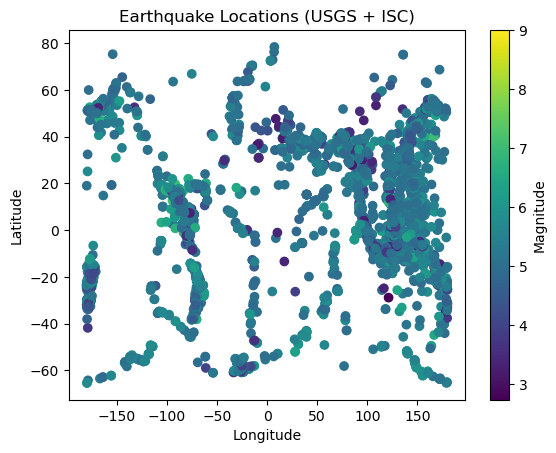

In [15]:
import matplotlib.pyplot as plt

# Plot earthquake locations
plt.scatter(combined_data['longitude'], combined_data['latitude'], c=combined_data['magnitude'], cmap='viridis')
plt.colorbar(label='Magnitude')
plt.title('Earthquake Locations (USGS + ISC)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

## Package the Tool

In [18]:
import argparse

def main():
    parser = argparse.ArgumentParser(description="Seismological Data Integration Tool")
    parser.add_argument('--fetch', action='store_true', help="Fetch and process data")
    parser.add_argument('--query', type=str, help="Query the database (e.g., 'magnitude > 6.0')")
    args = parser.parse_args()

    if args.fetch:
        # Fetch and process data
        usgs_data = fetch_usgs_data("2023-01-01", "2023-12-31", 5.0)
        isc_data = fetch_isc_data("2023-01-01", "2023-12-31", 5.0)
        usgs_data_clean = standardize_usgs_data(usgs_data)
        isc_data_clean = standardize_isc_data(isc_data)
        combined_data = pd.concat([usgs_data_clean, isc_data_clean], ignore_index=True)

        # Store in database
        conn = sqlite3.connect('seismological_data.db')
        cursor = conn.cursor()
        for _, row in combined_data.iterrows():
            cursor.execute('''
            INSERT INTO earthquakes (time, magnitude, longitude, latitude, source)
            VALUES (?, ?, ?, ?, ?)
            ''', (row['time'], row['magnitude'], row['longitude'], row['latitude'], row.get('source', 'Unknown')))
        conn.commit()
        conn.close()
        print("Data fetched and stored successfully.")

    elif args.query:
        # Query the database
        conn = sqlite3.connect('seismological_data.db')
        cursor = conn.cursor()
        cursor.execute(f"SELECT * FROM earthquakes WHERE {args.query}")
        results = cursor.fetchall()
        query_results = pd.DataFrame(results, columns=['id', 'time', 'magnitude', 'longitude', 'latitude', 'source'])
        print(query_results)
        conn.close()

if __name__ == "__main__":
    main()

usage: ipykernel_launcher.py [-h] [--fetch] [--query QUERY]
ipykernel_launcher.py: error: unrecognized arguments: -f /Users/zuhair/Library/Jupyter/runtime/kernel-95f48b32-207b-4d6d-8c92-ab41f687c587.json


SystemExit: 2

/Users/zuhair/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3534: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
